# History Weighted Regression

This notebook is a demonstration of the `mlfinlab.ensemble.history_weight_regression` module.
The method itself is based on the following three papers written by Megan Szasonis, Mark Kritzman and David Turkington.
    
1. [Addition by Subtraction: A Better Way to Forecast Factor Returns (and Everything Else). (2020)](https://www.statestreet.com/content/dam/statestreet/documents/ss_associates/Partial%20Sample%20Regressions_2019%2011%2019_2823811.1.1.GBL.pdf)

2. [Relevance. (2021)](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3803440)

3. [Partial Sample Regressions. (2019)](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3489520)

We mostly implement by choosing the consensus used in [Relevance] to be more consistent in notations.

In this notebook, we have the following parts for the demonstration:
1. Introduction and ideas
2. Key definitions and concepts
3. Demonstration
4. Expriments and verifications
5. Comments

## 1. Introduction and ideas

Intuitively, when we look at history data to make a reasonable guess of the current situation, we tend to at first identify similar cases to our current situation.
For example, say we are trying to predict a stock price with some companies' fundamental data (could be more than 1 company).
Then amongst those similar cases, we tend to take a deeper look at those that are farther away from the historical mean, because they usually bear more interesting information, and the average cases are plenty and they could just fluctuate due to noise.

Simply speaking, this is a method that selects a subsample based on how relevant each history instance in the training set is to our test instance, and run prediction on the subsample (i.e., a given percentage of all events ranked by relevance).
Moreover, when one chooses to use run prediction over all events (i.e., 100% of all events ranked by relevance), this method's result coincide with OLS.

## 2. Key definitions and concepts
Suppose we have an N-by-k data matrix $X$, with $N$ many instances and $k$ features.
Think about $X$ as our training set.
Then we can calculate the features **covariance matrix** (k-by-k) as
$$
\Omega = \frac{1}{N-1} X^T X
$$
And its inverse
$$
\Omega^{-1} = (N-1) (X^T X)^{-1}
$$

### Similarity
The **similarity** between two instances $(x_i, x_j)$:
$$
sim(x_i, x_j) = -\frac{1}{2} (x_i - x_j)^T \Omega^{-1} (x_i - x_j) \le 0
$$

### Informativeness
The **informativeness** as below of a single instance $x_i$:
$$
info(x_i) = \frac{1}{2} (x_i - \bar{x})^T \Omega^{-1} (x_i - \bar{x}) \ge 0
$$

### Relevance
The **relevance** value between two instances $(x_i, x_t)$:
$$
\begin{align}
    r(x_i, x_t) &= sim(x_i, x_t) + info(x_i) + info(x_t) \\
                &= -\frac{1}{2} (x_i - x_t)^T \Omega^{-1} (x_i - x_t) + \frac{1}{2} (x_i - \bar{x})^T \Omega^{-1} (x_i - \bar{x})
                + \frac{1}{2} (x_t - \bar{x})^T \Omega^{-1} (x_t - \bar{x}) \\
                &= (x_i - \bar{x})^T \Omega^{-1} (x_t - \bar{x})
    \end{align}
$$

Relevance is interpreted as the sum of similarity and informativeness for $(x_i, x_t)$, where $x_i$ is in the training set, and $x_t$ is a test instance.
Intuitively, when the in-sample instance and the test instance pair $(x_i, x_t)$ are similar and give great information, their relevance value will be greater.

### Subsample
Now given a test instance $x_t$, we can calculate its relevance value to all the instances to all the training instances.
We then rank the instances by their relevance value and choose the top $q \in (0, 1]$ quantile of the taining set to form a subsample.

### Prediction
The prediction value $\hat{y}_t$ based on the test instance $x_t$ is computed via:
$$   
\hat{y}_t = \bar{y} + \frac{1}{n-1} \sum_{i=1}^n r_{it} (y_i - \bar{y})
$$
where $\bar{y}$ is the subsample average of the training set $Y$, $n$ is the number of instances in the subsample.
When $q=1$, this method's prediction value is equivalent to that from OLS.

## 3. Demonstration

Below is a demonstration of using the history weighted regression method to predict US GDP, based on other macroeconomic data.
We at first run it with the original data, then we compare it with the rescaled data.
In general it is recommended to rescale the data properly for better numerical performance, and linear rescale for each feature does not change the prediction result mathematically.

In [1]:
# Import packages
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import decomposition
from sklearn.decomposition import PCA

# Import MlFinLab tools
from mlfinlab.regression.history_weight_regression import HistoryWeightRegression

In [2]:
# Get data: US macroeconomic data
data = sm.datasets.macrodata.load_pandas().data
X = data[['realcons', 'realgovt', 'unemp', 'm1']].to_numpy()
Y = data['realgdp'].to_numpy()
# Training data
training_len = 120
X_train = X[:training_len]
Y_train = Y[:training_len]
# Test Data
X_t = X[training_len:]
Y_t = Y[training_len:]
data[['realcons', 'realgovt', 'unemp', 'm1']]

,realcons,realgovt,unemp,m1
0,1707.4,470.045,5.8,139.7
1,1733.7,481.301,5.1,141.7
2,1751.8,491.260,5.3,140.5
3,1753.7,484.052,5.6,140.0
4,1770.5,462.199,5.2,139.6
...,...,...,...,...
198,9267.7,991.551,6.0,1474.7
199,9195.3,1007.273,6.9,1576.5
200,9209.2,996.287,8.1,1592.8
201,9189.0,1023.528,9.2,1653.6


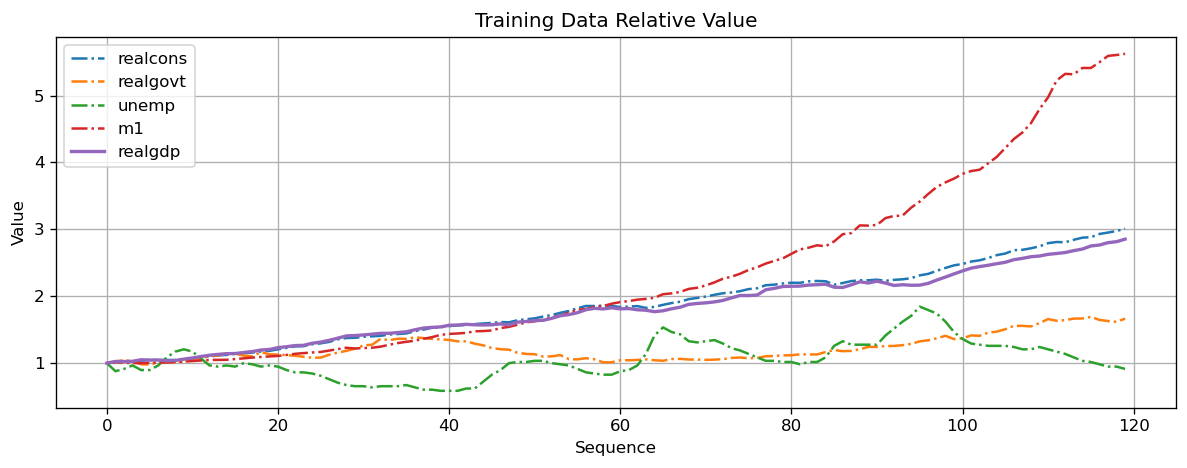

In [3]:
# Plot the data in the training set
fig, ax=plt.subplots(dpi=120, figsize=(10,4))
ax.plot(X_train[:,0] / X_train[0,0], '-.', label='realcons')
ax.plot(X_train[:,1] / X_train[0,1], '-.', label='realgovt')
ax.plot(X_train[:,2] / X_train[0,2], '-.', label='unemp')
ax.plot(X_train[:,3] / X_train[0,3], '-.', label='m1')
ax.plot(Y_train / Y_train[0], label='realgdp', linewidth=2)
ax.set_title('Training Data Relative Value')
ax.legend()
ax.grid()
ax.set_xlabel('Sequence')
ax.set_ylabel('Value')
fig.tight_layout()
plt.show()

In [4]:
# Show the covariance matrix and its inverse
hwr = HistoryWeightRegression(Y_train=Y_train, X_train=X_train)
hwr.get_fit_result()

{'Covariance matrix': array([[9.39570526e+05, 6.06771167e+04, 7.69541729e+02, 1.73966882e+05],
        [6.06771167e+04, 8.19343057e+03, 9.07239815e+00, 1.34463057e+04],
        [7.69541729e+02, 9.07239815e+00, 2.59537185e+00, 1.42654384e+02],
        [1.73966882e+05, 1.34463057e+04, 1.42654384e+02, 3.51697621e+04]]),
 'Inv of cov matrix': array([[ 1.48155666e-05,  3.21101200e-05,  2.54480750e-04,
         -8.65937962e-05],
        [ 3.21101200e-05,  5.62818285e-04,  1.16714521e-02,
         -4.21353660e-04],
        [ 2.54480750e-04,  1.16714521e-02,  7.50922017e-01,
         -8.76694736e-03],
        [-8.65937962e-05, -4.21353660e-04, -8.76694736e-03,
          6.53423423e-04]]),
 'Condition number of cov': 733077.514714746,
 'Cov mtx shape': (4, 4)}

You can also directly find the subsample of a test instance.

In [5]:
# Find subsample in the training set w.r.t. a test instance x_t
x_t = X_t[2]
# We get the subsample in X, subsample in Y, their index w.r.t. the original
# training set, and also the prediction std.
X_sub, Y_sub, sub_idx, std_yt_hat = hwr.find_subsample(x_t, relev_ratio_threshold=0.6)

Now we visually see how the relevance, informativeness and similarity value works, when calculated for a single test instance.

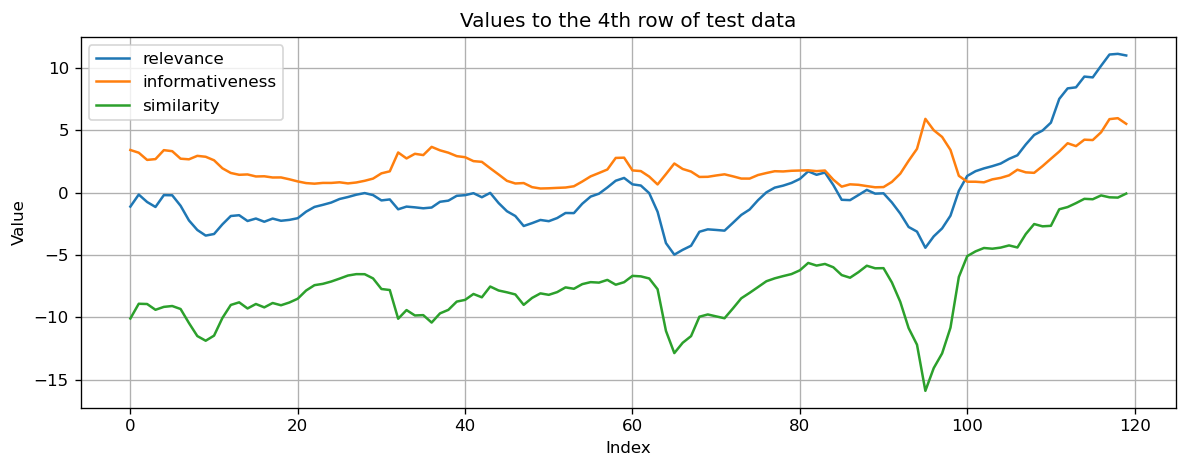

In [6]:
row_num=4
object_row = X_t[row_num]
relev_values = np.apply_along_axis(func1d=hwr.calc_relevance, axis=1, arr=hwr.X, x_j=object_row)
info_values = np.apply_along_axis(func1d=hwr.calc_info, axis=1, arr=hwr.X, fisher_info_mtx=hwr.fisher_info_mtx)
sim_values = np.apply_along_axis(func1d=hwr.calc_sim, axis=1, arr=hwr.X, x_j=object_row, fisher_info_mtx=hwr.fisher_info_mtx)

fig, ax=plt.subplots(dpi=120, figsize=(10,4))
ax.plot(relev_values, label='relevance')
ax.plot(info_values, label='informativeness')
ax.plot(sim_values, label='similarity')
ax.set_title('Values to the {}th row of test data'.format(row_num))
ax.legend()
ax.grid()
ax.set_xlabel('Index')
ax.set_ylabel('Value')
fig.tight_layout()
plt.show()

### Prediction, out-of-sample

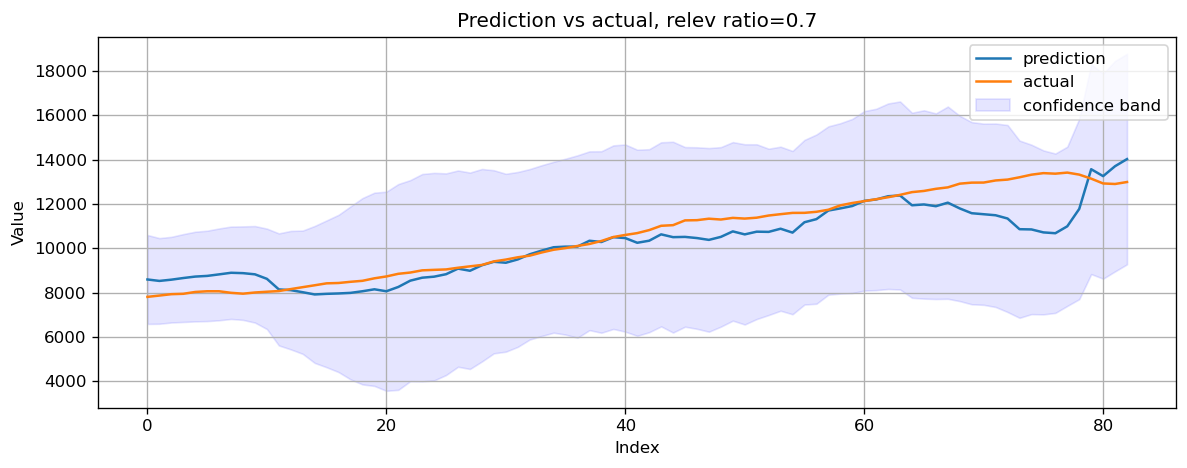

In [7]:
relev_ratio=0.7
pred_result = hwr.predict(X_t=X_t, relev_ratio_threshold=relev_ratio)
Y_predicts = pred_result[:, 0]
Y_std = pred_result[:, 1]
dummy_x = np.arange(0, len(X_t))

fig, ax=plt.subplots(dpi=120, figsize=(10,4))
ax.plot(dummy_x, Y_predicts, label='prediction')
ax.fill_between(dummy_x, (Y_predicts-Y_std), (Y_predicts+Y_std), color='b', alpha=.1, label='confidence band')
ax.plot(dummy_x, Y_t, label='actual')
ax.set_title('Prediction vs actual, relev ratio={}'.format(relev_ratio))
ax.legend()
ax.grid()
ax.set_xlabel('Index')
ax.set_ylabel('Value')
fig.tight_layout()
plt.show()

### Prediction, in-sample

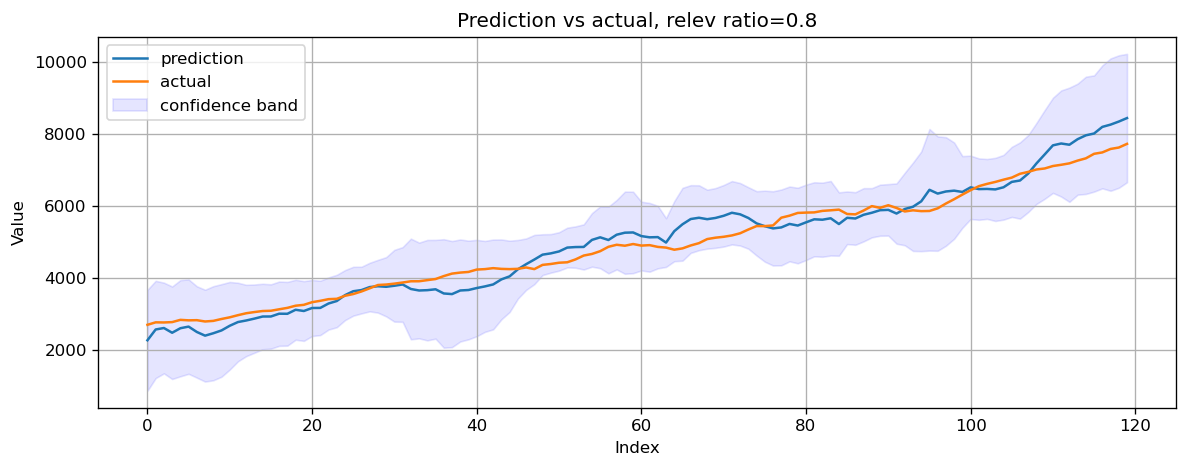

In [8]:
relev_ratio=0.8
predicts_result_in = hwr.predict(X_t=X_train, relev_ratio_threshold=relev_ratio)
Y_predicts_in = predicts_result_in[:, 0]
Y_std = predicts_result_in[:, 1]
dummy_x = np.arange(0, len(X_train))

fig, ax=plt.subplots(dpi=120, figsize=(10,4))
ax.plot(dummy_x, Y_predicts_in, label='prediction')
ax.fill_between(dummy_x, (Y_predicts_in-Y_std), (Y_predicts_in+Y_std), color='b', alpha=.1,
                label='confidence band')
ax.plot(dummy_x, Y_train, label='actual')
ax.set_title('Prediction vs actual, relev ratio={}'.format(relev_ratio))
ax.legend()
ax.grid()
ax.set_xlabel('Index')
ax.set_ylabel('Value')
fig.tight_layout()
plt.show()

## 4. Experiments and verifications

### 4.1. Compare the out-of-sample with OLS.
If `relev_ratio=1`, we expect identical results with OLS

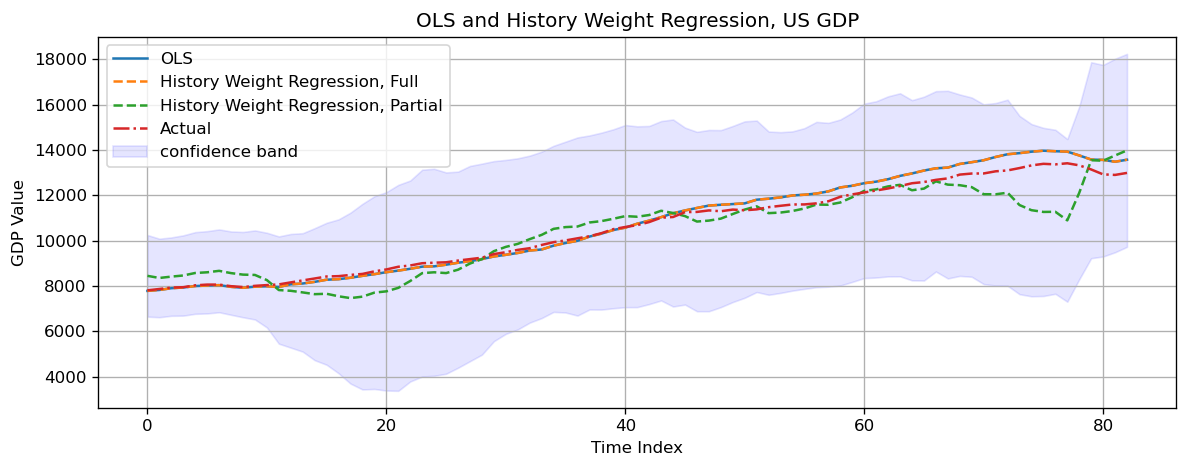

In [9]:
dummy_x = np.arange(0, len(Y_t))

# OLS fit
Y_ols = Y_train
X_ols = sm.add_constant(X_train)
ols_model = sm.OLS(Y_ols, X_ols)
ols_fit_results = ols_model.fit()

# OLS predict, out-of-sample
X_t_ols = sm.add_constant(X_t)
Y_predicts_ols = ols_fit_results.predict(X_t_ols)

# History Weighted Regression with full sample
Y_predicts_hwr = hwr.predict(X_t=X_t, relev_ratio_threshold=1)

# History Weighted Regression with partial sample
relev_ratio=0.8
Y_predicts_hwr_part = hwr.predict(X_t=X_t, relev_ratio_threshold=relev_ratio)

# Plot and compare
fig, ax=plt.subplots(dpi=120, figsize=(10,4))
ax.plot(Y_predicts_ols, label='OLS')
ax.plot(Y_predicts_hwr[:,0], '--', label='History Weight Regression, Full')
ax.plot(Y_predicts_hwr_part[:,0], '--', label='History Weight Regression, Partial')
ax.fill_between(dummy_x, (Y_predicts_hwr_part[:,0] - Y_predicts_hwr_part[:,1]),
                (Y_predicts_hwr_part[:,0] + Y_predicts_hwr_part[:,1]),
                color='b', alpha=.1, label='confidence band')
ax.plot(Y_t, '-.', label='Actual')
ax.set_title('OLS and History Weight Regression, US GDP')
ax.legend()
ax.grid()
ax.set_xlabel('Time Index')
ax.set_ylabel('GDP Value')
fig.tight_layout()
plt.show()

### 4.2 Check invariance under linear rescaling

Here I fit the scaler by the training set X, and rescale the traing set X and the test set X by the same scaler. The results are identical, as expected. But the condition number for the Fisher info matrix is much better. Note that I did not scale Y, for easier comparision. Also rescaling in Y is not as important.

In [10]:
# Get data: US macroeconomic data
# Only scale X according to the training data, keep Y the same
data = sm.datasets.macrodata.load_pandas().data
X = data[['realcons', 'realgovt', 'unemp', 'm1']].to_numpy()
Y = data['realgdp'].to_numpy()
# Training data
training_len = 120
X_train = X[:training_len]
Y_train = Y[:training_len]
# Scale the training data in X
scaler_X = preprocessing.StandardScaler()
scaler_X.fit(X_train)
X_train_scale = scaler_X.transform(X_train)  # Transform X training data
# Test Data, scale the test data in X
X_t_scale = scaler_X.transform(X[training_len:])  # Transform X test data
Y_t = Y[training_len:]

# Compare the condition number of covariance matrices (Smaller is better)
hwr_scale = HistoryWeightRegression(Y_train=Y_train, X_train=X_train_scale)
print('Scaled')
print(hwr_scale.get_fit_result())
print('Unscaled')
print(hwr.get_fit_result())
print('The condition number is much better')

Scaled
{'Covariance matrix': array([[1.00840336, 0.6973674 , 0.49693773, 0.96505365],
       [0.6973674 , 1.00840336, 0.06273699, 0.79876616],
       [0.49693773, 0.06273699, 1.00840336, 0.47614025],
       [0.96505365, 0.79876616, 0.47614025, 1.00840336]]), 'Inv of cov matrix': array([[ 13.80426743,   2.79386376,   0.39408067, -15.60996401],
       [  2.79386376,   4.5729841 ,   1.68780897,  -7.09300212],
       [  0.39408067,   1.68780897,   1.93268085,  -2.62662833],
       [-15.60996401,  -7.09300212,  -2.62662833,  22.78924009]]), 'Condition number of cov': 104.31355827491704, 'Cov mtx shape': (4, 4)}
Unscaled
{'Covariance matrix': array([[9.39570526e+05, 6.06771167e+04, 7.69541729e+02, 1.73966882e+05],
       [6.06771167e+04, 8.19343057e+03, 9.07239815e+00, 1.34463057e+04],
       [7.69541729e+02, 9.07239815e+00, 2.59537185e+00, 1.42654384e+02],
       [1.73966882e+05, 1.34463057e+04, 1.42654384e+02, 3.51697621e+04]]), 'Inv of cov matrix': array([[ 1.48155666e-05,  3.21101200e-05

Next, we compare the results with the original unscaled data version.
From the plot we can see that they are indeed identical.

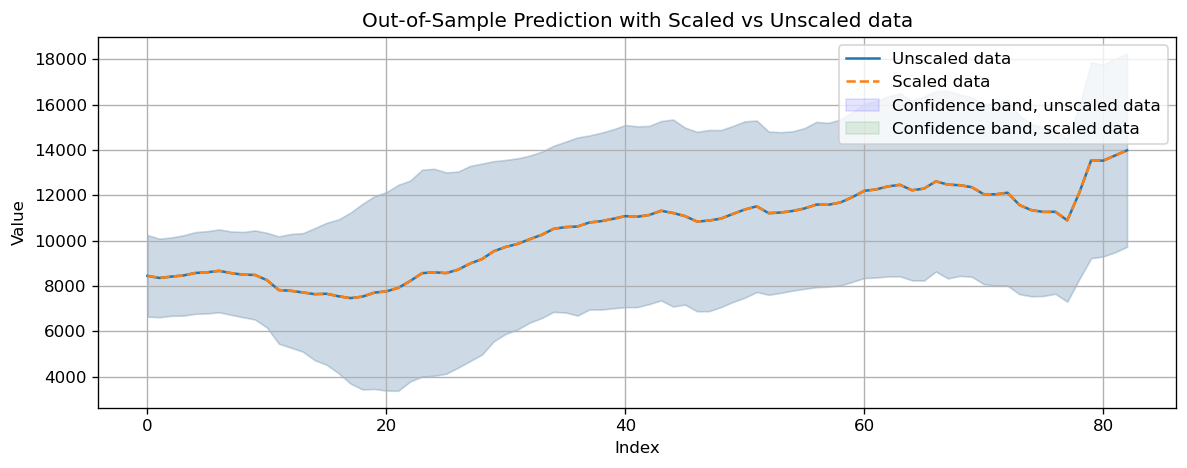

In [11]:
dummy_x = np.arange(0, len(Y_t))
relev_ratio=0.8

# History Weighted Regression with partial sample, unscaled data
Y_predicts_hwr_part = hwr.predict(X_t=X_t, relev_ratio_threshold=relev_ratio)
# Scaled data
Y_predicts_hwr_scale_part = hwr_scale.predict(X_t=X_t_scale, relev_ratio_threshold=relev_ratio)
# Plot and compare
fig, ax=plt.subplots(dpi=120, figsize=(10,4))
# Unscaled
ax.plot(Y_predicts_hwr_part[:,0], '-', label='Unscaled data')
ax.fill_between(dummy_x, (Y_predicts_hwr_part[:,0] - Y_predicts_hwr_part[:,1]),
                (Y_predicts_hwr_part[:,0] + Y_predicts_hwr_part[:,1]),
                color='b', alpha=.1, label='Confidence band, unscaled data')
# Scaled
ax.plot(Y_predicts_hwr_scale_part[:,0], '--', label='Scaled data')
ax.fill_between(dummy_x, (Y_predicts_hwr_scale_part[:,0] - Y_predicts_hwr_scale_part[:,1]),
                (Y_predicts_hwr_scale_part[:,0] + Y_predicts_hwr_scale_part[:,1]),
                color='g', alpha=.1, label='Confidence band, scaled data')

ax.set_title('Out-of-Sample Prediction with Scaled vs Unscaled data')
ax.legend()
ax.grid()
ax.set_xlabel('Index')
ax.set_ylabel('Value')
fig.tight_layout()
plt.show()

### 4.3. Test result using different quantiles
Here we plot the predictions (out-of-sample) using different quantile values for choosing the subsample.
The less transparent the plot line, the closer it is to a full sample (i.e., $q$ close to 1).

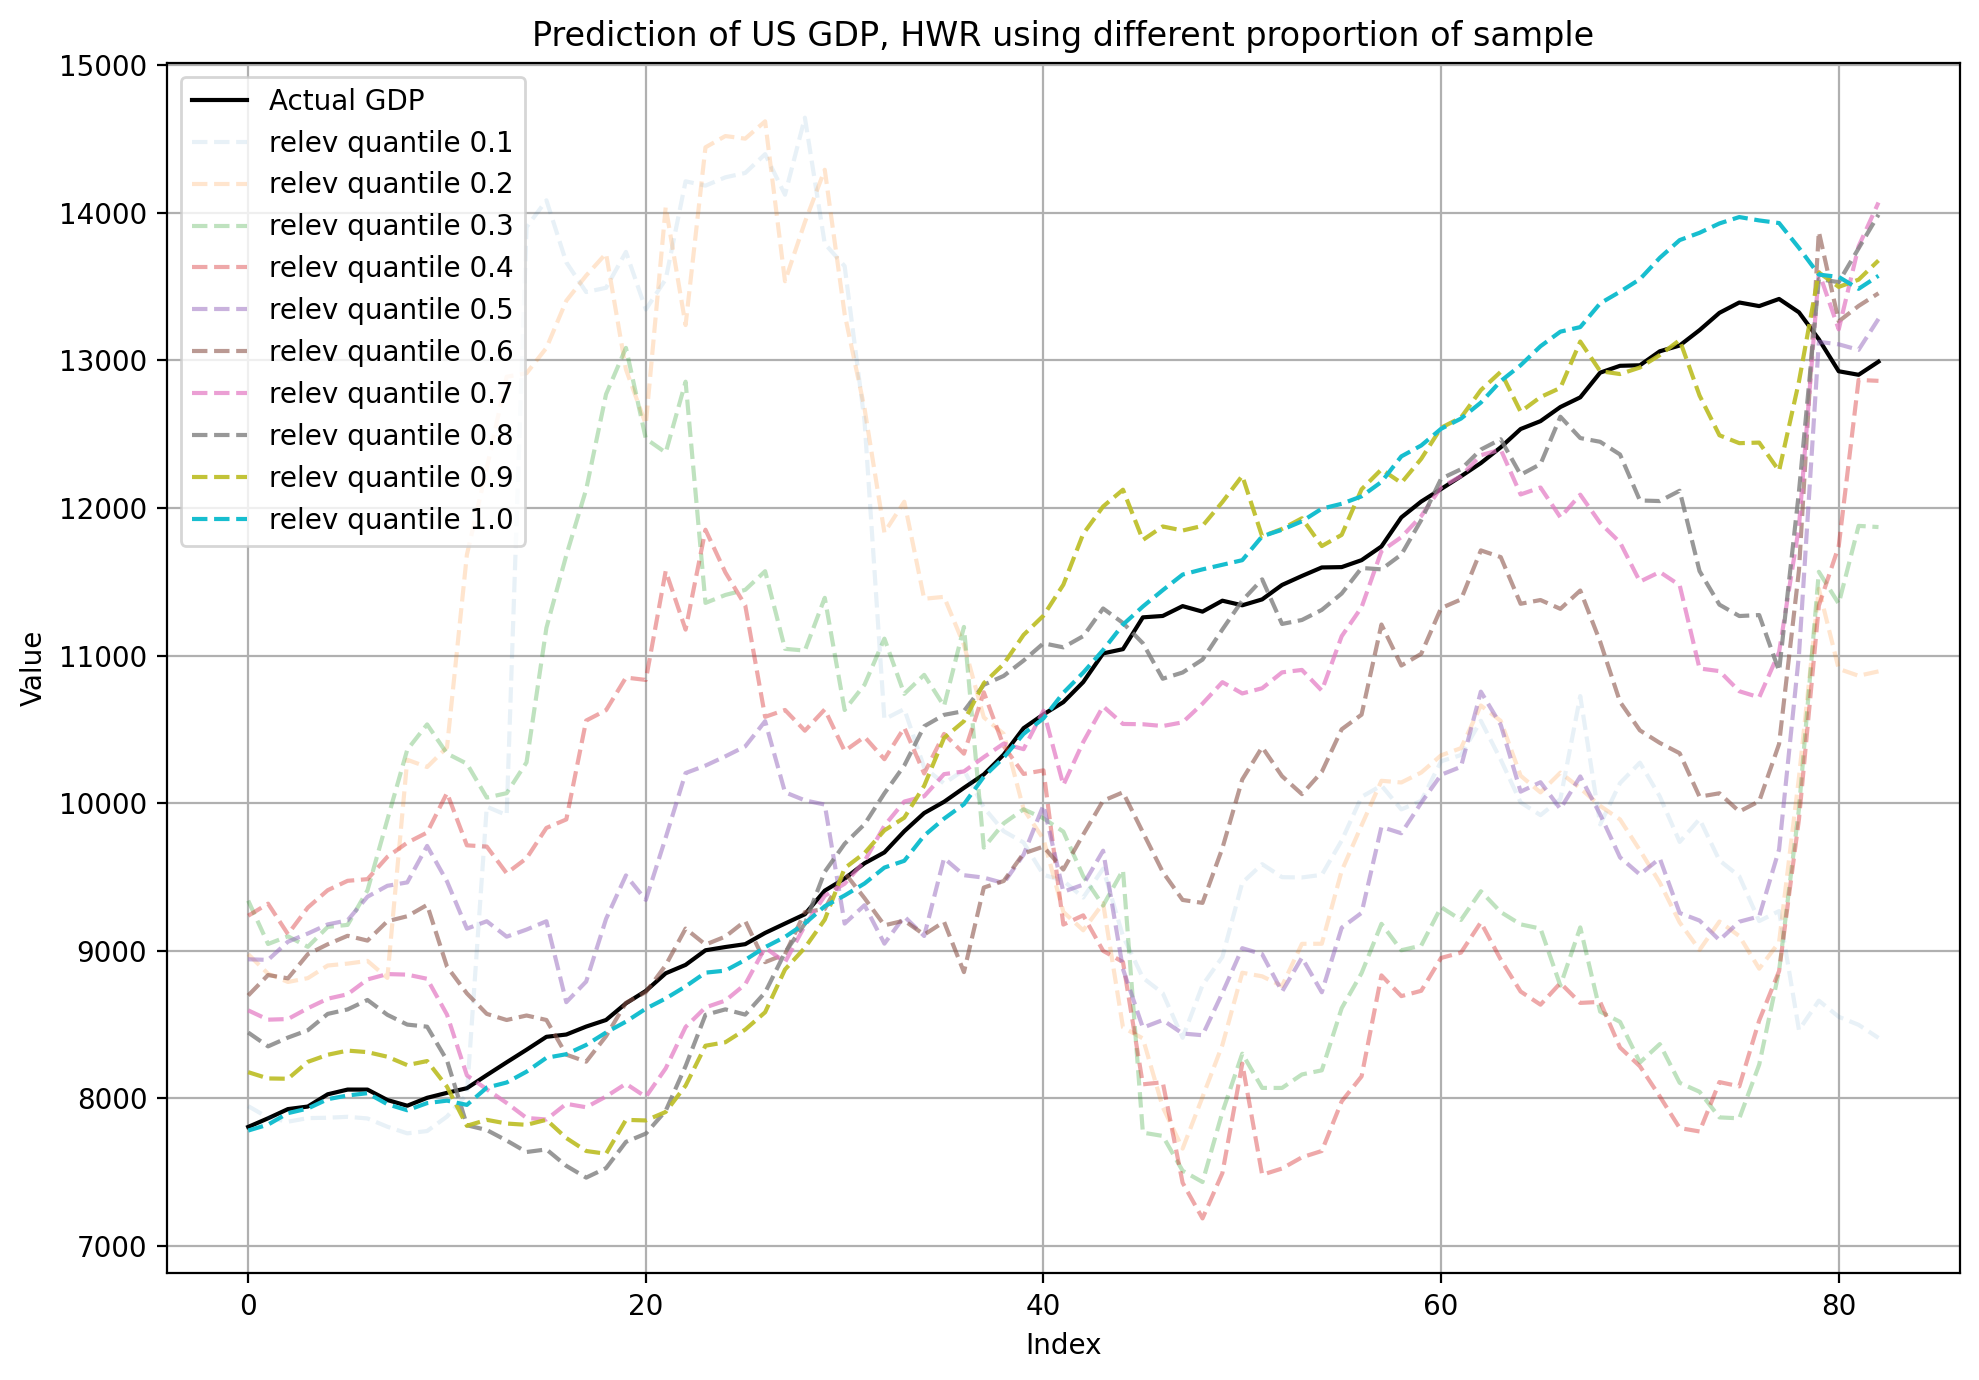

In [12]:
quantiles = np.linspace(0.1, 1, 10)

# 1. HWR with different quantiles
hwr_results = dict()
hwr = HistoryWeightRegression(Y_train=Y_train, X_train=X_train_scale)
for quantile in quantiles:
    hwr_results[quantile] = hwr.predict(X_t=X_t_scale, relev_ratio_threshold=quantile)

fig, ax=plt.subplots(dpi=200, figsize=(10,7))

ax.plot(dummy_x, Y_t, label='Actual GDP', color='black')
for quantile in quantiles:
    ax.plot(dummy_x, hwr_results[quantile][:,0], '--', label='relev quantile {:.1f}'.format(quantile),
            alpha=quantile)

ax.set_title('Prediction of US GDP, HWR using different proportion of sample')
ax.legend()
ax.grid()
ax.set_xlabel('Index')
ax.set_ylabel('Value')
fig.tight_layout()
plt.show()

### 4.4. Compare with PCA

Both PCA and this history weighted regression method (HWR) ultilizes the covariance matrix, though HWR picks the relevant instances and PCA reduces dimension by getting rid of features.

With 10 features in our data, I am interested in comparing out-of-sample predictions for the HWR method with top 50 percentile instances, and OLS on a dataset with top 5 principle components picked by PCA.

Note: This is not an attempt to demonstrate which method is universally better or worse. Different methods and modeling techniques have different emphasis on interpreting the data. The actual usage of them are in general highly situational. Indeed, here we have only one set of macroeconomic data, hence the purpose of the demonstration is to show that the history weighted regression method is NOT equivalent to PCA, and they capture different aspects of the data.

In [13]:
# Get data: US macroeconomic data, 10 features
data = sm.datasets.macrodata.load_pandas().data
X = data[['realcons', 'realinv', 'realgovt', 'cpi', 'm1',
          'tbilrate', 'unemp', 'pop', 'infl', 'realint']].to_numpy()
Y = data['realgdp'].to_numpy()
# Training data
training_len = 120
X_train = X[:training_len]
Y_train = Y[:training_len]
# Scale the training data in X
scaler_X = preprocessing.StandardScaler()
scaler_X.fit(X_train)
X_train_scale = scaler_X.transform(X_train)  # Transform X training data
# Test Data, scale the test data in X
X_t_scale = scaler_X.transform(X[training_len:])  # Transform X test data
Y_t = Y[training_len:]

# Predict out-of-sample results with top 50 percentile using HWR
quantile = 0.5
hwr = HistoryWeightRegression(Y_train=Y_train, X_train=X_train_scale)
hwr_predicts = hwr.predict(X_t=X_t_scale, relev_ratio_threshold=quantile)

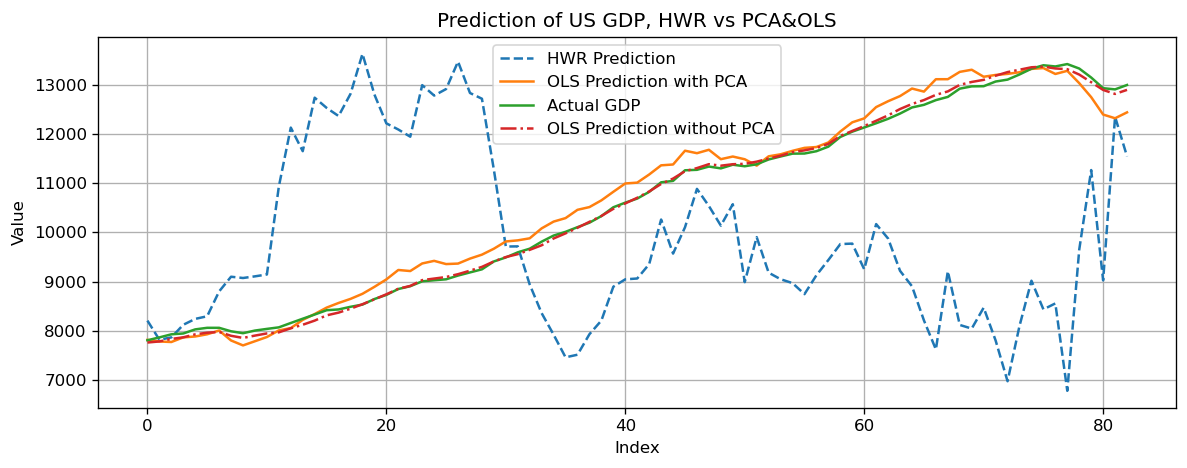

In [14]:
# Take the top 5 relevant features using PCA on rescaled data
pca = PCA(n_components=5)
pca.fit(X_train_scale)
X_pca_train = pca.transform(X_train_scale)
X_pca_t = pca.transform(X_t_scale)

# Conduct OLS on the PCA-select training set
# OLS fit
Y_ols = Y_train
X_ols = sm.add_constant(X_pca_train)
ols_model = sm.OLS(Y_ols, X_ols)
ols_fit_results = ols_model.fit()

# OLS predict, out-of-sample
X_t_ols = sm.add_constant(X_pca_t)
Y_predicts_ols = ols_fit_results.predict(X_t_ols)

# Benchmark against the original OLS. We use HWR over the full sample
hwr_predicts_ols = hwr.predict(X_t=X_t_scale, relev_ratio_threshold=1)

# Plot and overlay with the HWR result
# Plot the prediction
dummy_x = np.arange(0, len(Y_t))
fig, ax=plt.subplots(dpi=120, figsize=(10,4))

ax.plot(dummy_x, hwr_predicts[:, 0], '--', label='HWR Prediction')
ax.plot(dummy_x, Y_predicts_ols, label='OLS Prediction with PCA')
# ax.fill_between(dummy_x, (hwr_predicts[:,0] - hwr_predicts[:,1]),
#                 (hwr_predicts[:,0] + hwr_predicts[:,1]),
#                 color='g', alpha=.1, label='Confidence band')
ax.plot(dummy_x, Y_t, label='Actual GDP')
ax.plot(dummy_x, hwr_predicts_ols[:, 0], '-.', label='OLS Prediction without PCA')

ax.set_title('Prediction of US GDP, HWR vs PCA&OLS')
ax.legend()
ax.grid()
ax.set_xlabel('Index')
ax.set_ylabel('Value')
fig.tight_layout()
plt.show()

Also that pre-filter the features by PCA does not seem to make the partial sample regression prediction noticeably better (or worse).
This needs further examination in theory.

## Conclusion

Most of the summaries and comments below are taken directly from the three articles, though may be worded slightly differently.

1. The prediction from a linear regression equation is mathematically equivalent to a weighted average of past values of the dependent variable in which the weights are the relevance of the independent variables.

2. This equivalence allows one to form a relevance-weighted prediction of the dependent variable by using only a subsample of relevant observations. This approach is called partial sample regression.
   
3. Like partial sample regression, an event study separates relevant observations from non-relevant observations, but it does so by identification rather than mathematically.
   
4. We should also note that our approach is different from weighted least squares regression, which uses fixed weights regardless of the data point being predicted and applies the weights to calculate the covariance matrix among predictors.

5. This regression method is different from performing separate regressions on subsamples of the most relevant observations; in a separate regression approach, the covariance matrix used for estimation would also be based on the subsample, whereas we always use the full-sample covariance matrix.

6. The calculation is invariant under linear re-scale of $X$. Rescale to get a better condition number for $\Omega^{-1}$.

7. This method is conceptually different from PCA, where feature importance were considered. This regression method considers the importance in instances, not features. However, one can combine the PCA transformation and the partial sample regression, and if all principle components are considered, the prediction result will be identical compared to directly working with $X$.

## References

* [Czasonis, M., Kritzman, M. and Turkington, D., 2020. Addition by Subtraction: A Better Way to Forecast Factor Returns (and Everything Else). The Journal of Portfolio Management, 46(8), pp.98-107.](https://www.statestreet.com/content/dam/statestreet/documents/ss_associates/Partial%20Sample%20Regressions_2019%2011%2019_2823811.1.1.GBL.pdf)
* [Czasonis, M., Kritzman, M. and Turkington, D., 2021. Relevance.](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3803440)
* [Czasonis, M., Kritzman, M. and Turkington, D., 2019. Partial Sample Regressions.](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3489520)